In [1]:
from os import listdir
from tqdm import tqdm
import xml.etree.ElementTree as ET
# import modules & set up logging
import numpy as np
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import remove_stopwords
# Load word2vec pre-train model
import gensim
import gensim.downloader as api
import gensim.models.keyedvectors as word2vec
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [3]:
use_POS = False

## Get all the sentences (text) and the correspondent entailments (hypothesis) from the dataset

In [4]:
PATH = "./rteFormatData"

In [5]:
files = [f for f in listdir(PATH)]
trees = []
entailment_pairs = []
sentences = []

for file in files:
    trees.append(ET.parse(PATH+'/'+file))

for tree in trees:
    root = tree.getroot()
    for pair in root.findall('pair'):
        if pair.attrib['entailment'] == 'ENTAILMENT':
            text = pair.find('t').text.lower()
            hypothesis = pair.find('h').text.lower()
            sentences.append(text)
            sentences.append(hypothesis)
            entailment_pairs.append((text, hypothesis))

# Remove duplicates
entailment_pairs = list(set([i for i in entailment_pairs]))

## Load a pre-trained model for evaluation

In [12]:
path = api.load("word2vec-google-news-300", return_path=True)
gn_model = word2vec.KeyedVectors.load_word2vec_format(path, binary=True)
#weights = torch.FloatTensor(gn_model.wv.vectors)

[=================================================-] 99.9% 1661.7/1662.8MB downloaded


In [31]:
path

'C:\\Users\\aless/gensim-data\\word2vec-google-news-300\\word2vec-google-news-300.gz'

## Get linguistic features with Spacy

In [14]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

### Generate token word_POS

In [15]:
def add_POS(entailment_pairs):
    entailment_pairs_pos = []
    sentences_pos = []
    for i in tqdm(range(len(entailment_pairs))):
        pair = []
        for j in range(2): 
            doc = nlp(entailment_pairs[i][j].lower())
            pos = [token.pos_ for token in doc]
            sentences_pos.append(list(map('_'.join, zip(doc.text.split(), pos))))
            pair.append(list(map('_'.join, zip(doc.text.split(), pos))))
        entailment_pairs_pos.append(pair)

    return entailment_paris_pos, sentences_pos

if use_POS:
    entailment_pairs, sentences = add_POS(entailment_pairs)

## Generate corpus based on dataset sentences

In [16]:
# train word2vec on the two sentences
V = Dictionary([['<#S>','<#E>','<PAD>']])
for sentence in sentences:
    V.add_documents([sentence.split()])

In [17]:
def sentence_decoration(sentence):
    #return sentence.lower().split()
    return ['<#S>'] + sentence.lower().split() + ['<#E>']

In [18]:
training = []

for text, hypothesis in entailment_pairs:
    #text = text.lower().split()
    text = sentence_decoration(text)
    #hypothesis = hypothesis.lower().split()
    hypothesis = sentence_decoration(hypothesis)
    padding = len(text) if len(text) > len(hypothesis) else len(hypothesis)
  
    if len(text) < padding:
        text = text + ['<PAD>'] * (padding-len(text))
    elif len(hypothesis) < padding:
        hypothesis = hypothesis + ['<PAD>'] * (padding-len(hypothesis))
    
    training.append((text, hypothesis))

## LSTM model

In [19]:
class LSTMlm(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMlm, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,num_layers=3, batch_first=False)

        # The linear layer that maps from hidden state space to target space
        self.hidden2tag = nn.Linear(hidden_dim, target_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Train

In [20]:
def evaluation_sequence(seq, dictionary):
    return [gn_model[token] for token in seq if token in gn_model.vocab]

In [21]:
def training_sequence(seq, dictionary):
    idxs = dictionary.doc2idx(seq)
    # remove unknown tokens
    if -1 in idxs: idxs.remove(-1)
    return torch.tensor(idxs, dtype=torch.long)

In [22]:
EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TARGET_SIZE = 64, 64, len(V), len(V)
model = LSTMlm(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TARGET_SIZE)
loss_function = nn.NLLLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=0.1)

https://github.com/afflint/inforet/blob/master/thematic-studies/language-models/L10-dialogue-generation.ipynb

## Model Evaluation

In [23]:
def apply_model(pairs):
    text_target_answer = []
    for text, target in pairs:
        doc = sentence_decoration(text)
        if use_POS:
            pos = [token.pos_ for token in doc]
            doc = list(map('_'.join, zip(doc.text.split(), pos)))

        s = training_sequence(doc, V)

        hypothesis = []
        for tensor in model(s):
            token_idx = tensor.argmax().item()
            hypothesis.append(V[token_idx])

        answer = ""
        for token in hypothesis:
            word = token.split('_')[0]
            #if word != "<PAD>" and word != "<#S>" and word != "<#E>":
            answer += word + " "

        text_target_answer.append((text, target, answer))

    return text_target_answer

In [24]:
def compute_cos_sim(sentence1, sentence2):
    sentence1 = remove_stopwords(sentence1)
    sentence2 = remove_stopwords(sentence2)
    sentence1 = torch.Tensor(np.array(evaluation_sequence(sentence1.split(), gn_model))).mean(dim=0)
    sentence2 = torch.Tensor(np.array(evaluation_sequence(sentence2.split(), gn_model))).mean(dim=0)
    output = F.cosine_similarity(sentence1, sentence2, dim=0)
    return output

In [25]:
import math

def evaluate_model(entailment_pairs):
    cos_sim = []
    n_nan = 0
    text_target_answer = apply_model(entailment_pairs)
    for tri in text_target_answer:
        _, target, answer = tri
        output = compute_cos_sim(target,answer)
        if (math.isnan(output)):
            n_nan += 1
        else:
            cos_sim.append(output)
            
    mean_cos_sim = sum(cos_sim) / len(cos_sim)
    return mean_cos_sim, n_nan

In [26]:
N_EPOCHS = 30
SAMPLE_RATE = 5
cos_sim_mean = []
n_nan = []

for idx in tqdm(range(N_EPOCHS)):
    for text, hypothesis in training:
        model.zero_grad()
        sent = training_sequence(text, V)
        target = training_sequence(hypothesis, V)
        scores = model(sent)
        loss = loss_function(scores, target)
        loss.backward()
        optimizer.step()

    if idx % SAMPLE_RATE == 0:
        mean_, n_nan_ = evaluate_model(entailment_pairs)
        cos_sim_mean.append(mean_)
        n_nan.append(n_nan_)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [25:00<00:00, 50.02s/it]


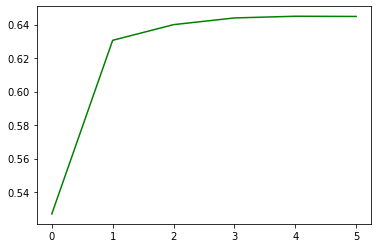

In [27]:
import matplotlib.pyplot as plt

epochs = range(0, int(N_EPOCHS/SAMPLE_RATE))
plt.plot(epochs, cos_sim_mean, 'g', label='Cosine similarity mean')
#plt.plot(epochs, n_nan, 'r', label='Missing answers')

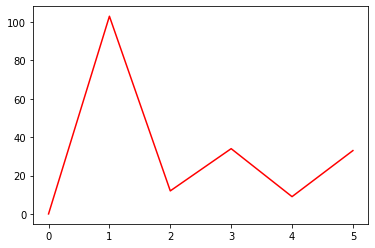

In [28]:
plt.plot(epochs, n_nan, 'r', label='Missing answers')

In [29]:
text_target_answer = apply_model(entailment_pairs)

In [32]:
i = 11
print('text: ', text_target_answer[i][0], '\ntarget: ', text_target_answer[i][1], '\nanswer: ', text_target_answer[i][2])

text:  more leg room would have been perfect 
target:  more leg space 
answer:  <#S> more leg room <PAD> <PAD> <PAD> <PAD> <PAD> 
